![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/4.Clinical_DeIdentification.ipynb)


# Clinical Deidentification

## Colab Setup

In [ ]:
import json
import os

from google.colab import files

if 'spark_jsl.json' not in os.listdir():
  license_keys = files.upload()
  os.rename(list(license_keys.keys())[0], 'spark_jsl.json')

with open('spark_jsl.json') as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)
os.environ.update(license_keys)

In [ ]:
# Installing pyspark and spark-nlp
! pip install --upgrade -q pyspark==3.1.2 spark-nlp==$PUBLIC_VERSION

# Installing Spark NLP Healthcare
! pip install --upgrade -q spark-nlp-jsl==$JSL_VERSION  --extra-index-url https://pypi.johnsnowlabs.com/$SECRET

In [ ]:
import json
import os

from pyspark.ml import Pipeline, PipelineModel
from pyspark.sql import SparkSession

import sparknlp
import sparknlp_jsl

from sparknlp.annotator import *
from sparknlp_jsl.annotator import *
from sparknlp.base import *
from sparknlp.util import *
from sparknlp.pretrained import ResourceDownloader
from pyspark.sql import functions as F

import pandas as pd

pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

import string
import numpy as np

params = {"spark.driver.memory":"16G",
          "spark.kryoserializer.buffer.max":"2000M",
          "spark.driver.maxResultSize":"2000M"}

spark = sparknlp_jsl.start(secret = SECRET, params=params)

print ("Spark NLP Version :", sparknlp.version())
print ("Spark NLP_JSL Version :", sparknlp_jsl.version())

spark

Spark NLP Version : 4.0.0
Spark NLP_JSL Version : 4.0.0


In [ ]:
# if you want to start the session with custom params as in start function above
from pyspark.sql import SparkSession

def start(SECRET):
    builder = SparkSession.builder \
        .appName("Spark NLP Licensed") \
        .master("local[*]") \
        .config("spark.driver.memory", "16G") \
        .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
        .config("spark.kryoserializer.buffer.max", "2000M") \
        .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:"+PUBLIC_VERSION) \
        .config("spark.jars", "https://pypi.johnsnowlabs.com/"+SECRET+"/spark-nlp-jsl-"+JSL_VERSION+".jar")
      
    return builder.getOrCreate()

#spark = start(SECRET)

# Deidentification Model

Protected Health Information: 
- individual’s past, present, or future physical or mental health or condition
- provision of health care to the individual
- past, present, or future payment for the health care 

Protected health information includes many common identifiers (e.g., name, address, birth date, Social Security Number) when they can be associated with the health information.

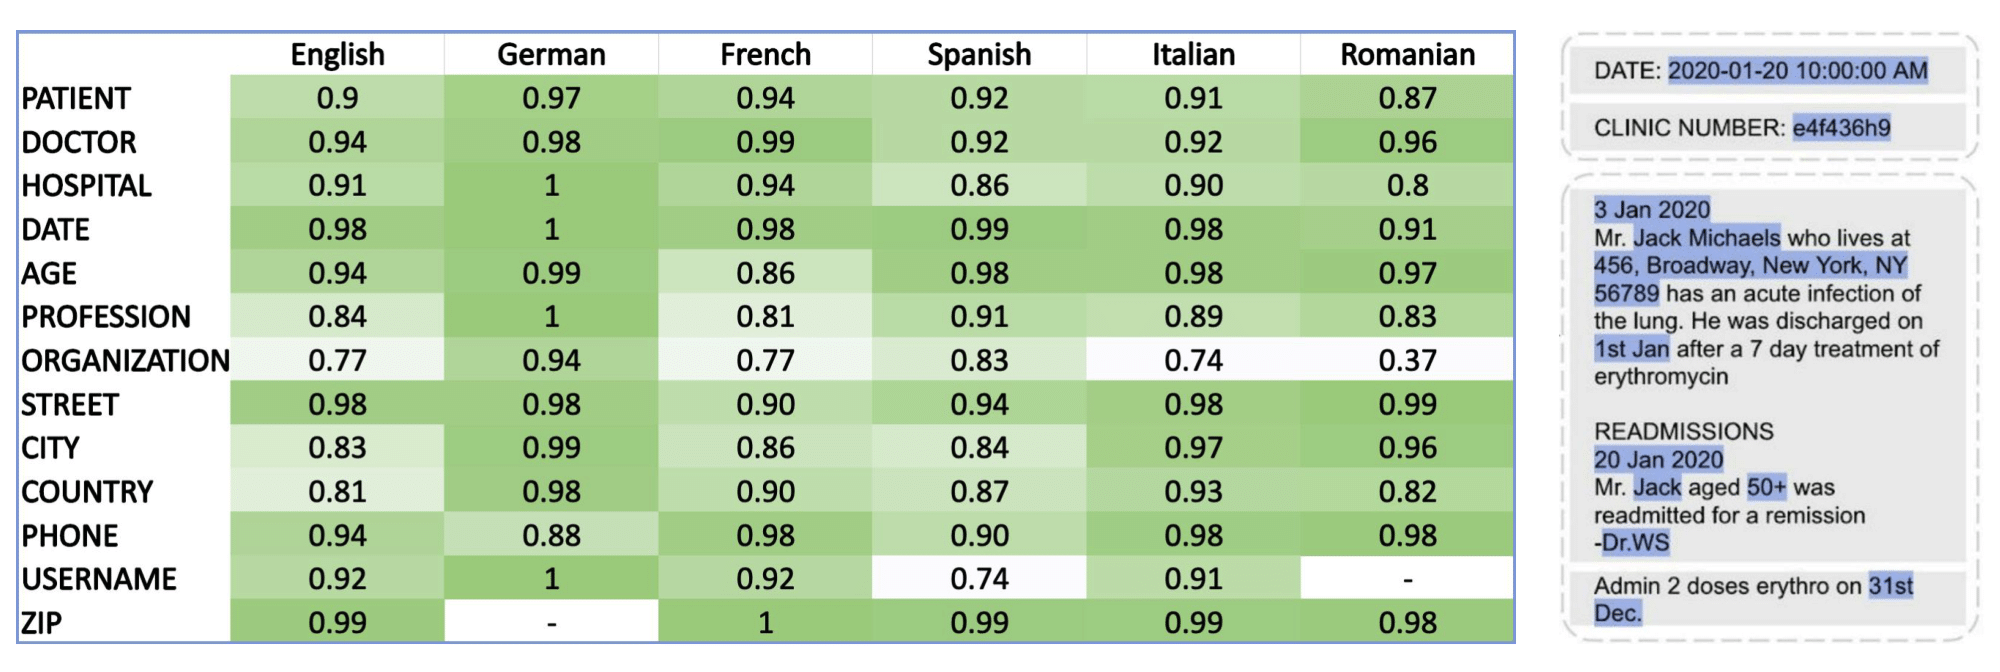

<center><b>Deidentification NER Models for English</b></center>

|index|model|lang|index|model|lang|index|model|lang|
|-----:|:-----|----|-----:|:-----|----|-----:|:-----|----|
| 1| [deidentify_dl](https://nlp.johnsnowlabs.com/2021/01/28/deidentify_dl_en.html)  |en| 7| [ner_deid_enriched_biobert](https://nlp.johnsnowlabs.com/2021/04/01/ner_deid_enriched_biobert_en.html)  |en| 13| [ner_deid_subentity_augmented](https://nlp.johnsnowlabs.com/2021/09/03/ner_deid_subentity_augmented_en.html)  |en|
| 2| [deidentify_large](https://nlp.johnsnowlabs.com/2020/08/04/deidentify_large_en.html)  |en| 8| [ner_deid_generic_augmented](https://nlp.johnsnowlabs.com/2021/06/30/ner_deid_generic_augmented_en.html)  |en| 14| [ner_deid_subentity_augmented_i2b2](https://nlp.johnsnowlabs.com/2021/11/29/ner_deid_subentity_augmented_i2b2_en.html)  |en|
| 3| [deidentify_rb](https://nlp.johnsnowlabs.com/2019/06/04/deidentify_rb_en.html)  |en| 9| [ner_deid_generic_glove](https://nlp.johnsnowlabs.com/2021/06/06/ner_deid_generic_glove_en.html)  |en| 15| [ner_deid_subentity_glove](https://nlp.johnsnowlabs.com/2021/06/06/ner_deid_subentity_glove_en.html)  |en|
| 4| [ner_deid_augmented](https://nlp.johnsnowlabs.com/2021/03/31/ner_deid_augmented_en.html)  |en| 10| [ner_deid_large](https://nlp.johnsnowlabs.com/2021/03/31/ner_deid_large_en.html)  |en| 16| [ner_deid_synthetic](https://nlp.johnsnowlabs.com/2021/03/31/ner_deid_synthetic_en.html)  |en|
| 5| [ner_deid_biobert](https://nlp.johnsnowlabs.com/2021/04/01/ner_deid_biobert_en.html)  |en| 11| [ner_deid_sd](https://nlp.johnsnowlabs.com/2021/04/01/ner_deid_sd_en.html)  |en| 17| [ner_deidentify_dl](https://nlp.johnsnowlabs.com/2021/03/31/ner_deidentify_dl_en.html)  |en|
| 6| [ner_deid_enriched](https://nlp.johnsnowlabs.com/2021/03/31/ner_deid_enriched_en.html)  |en| 12| [ner_deid_sd_large](https://nlp.johnsnowlabs.com/2021/04/01/ner_deid_sd_large_en.html)  |en| 18| []()|


<center><b>Deidentification NER Models for Other Languages</b></center>

|index|model|lang|index|model|lang|
|-----:|:-----|----|-----:|:-----|----|
| 1| [ner_deid_generic](https://nlp.johnsnowlabs.com/2022/01/06/ner_deid_generic_de.html)  |de| 11| [ner_deid_generic](https://nlp.johnsnowlabs.com/2022/02/11/ner_deid_generic_fr.html)  |fr|
| 2| [ner_deid_subentity](https://nlp.johnsnowlabs.com/2022/01/06/ner_deid_subentity_de.html)  |de| 12| [ner_deid_subentity](https://nlp.johnsnowlabs.com/2022/02/14/ner_deid_subentity_fr.html)  |fr|
| 3| [ner_deid_generic](https://nlp.johnsnowlabs.com/2022/01/18/ner_deid_generic_es.html)  |es| 13| [ner_deid_generic](https://nlp.johnsnowlabs.com/2022/03/25/ner_deid_generic_it_3_0.html)  |it|
| 4| [ner_deid_generic_augmented](https://nlp.johnsnowlabs.com/2022/02/16/ner_deid_generic_augmented_es.html)  |es| 14| [ner_deid_subentity](https://nlp.johnsnowlabs.com/2022/03/25/ner_deid_subentity_it_2_4.html)  |it|
| 5| [ner_deid_generic_roberta](https://nlp.johnsnowlabs.com/2022/01/17/ner_deid_generic_roberta_es.html)  |es| 15| [ner_deid_generic](https://nlp.johnsnowlabs.com/2022/04/13/ner_deid_generic_pt_3_0.html)  |pt|
| 6| [ner_deid_generic_roberta_augmented](https://nlp.johnsnowlabs.com/2022/02/16/ner_deid_generic_roberta_augmented_es.html)  |es| 16| [ner_deid_subentity](https://nlp.johnsnowlabs.com/2022/04/13/ner_deid_subentity_pt_3_0.html)  |pt|
| 7| [ner_deid_subentity](https://nlp.johnsnowlabs.com/2022/01/18/ner_deid_subentity_es.html)  |es| 17| [ner_deid_subentity](https://nlp.johnsnowlabs.com/2022/06/27/ner_deid_subentity_ro_3_0.html)  |ro|
| 8| [ner_deid_subentity_augmented](https://nlp.johnsnowlabs.com/2022/02/16/ner_deid_subentity_augmented_es.html)  |es| 18| [ner_deid_subentity_bert](https://nlp.johnsnowlabs.com/2022/06/27/ner_deid_subentity_bert_ro_3_0.html)  |ro|
| 9| [ner_deid_subentity_roberta](https://nlp.johnsnowlabs.com/2022/01/17/ner_deid_subentity_roberta_es.html)  |es| 19| [ner_deid_generic](https://nlp.johnsnowlabs.com/models)  |ro|
| 10| [ner_deid_subentity_roberta_augmented](https://nlp.johnsnowlabs.com/2022/02/16/ner_deid_subentity_roberta_augmented_es.html)  |es| 20| [ner_deid_generic_bert](https://nlp.johnsnowlabs.com/models)  |ro|


You can find German, Spanish, French, Italian, Portuguese and Romanian deidentification models and pretrained pipeline examples in this notebook:   [Clinical Multi Language Deidentification Notebook](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/4.1.Clinical_Multi_Language_Deidentification.ipynb)


**Let's start!**

Load NER pipeline to identify protected entities:

In [ ]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

# Sentence Detector annotator, processes various sentences per line
sentenceDetector = SentenceDetector()\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

# Tokenizer splits words in a relevant format for NLP
tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

# Clinical word embeddings trained on PubMED dataset
word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

# NER model trained on n2c2 (de-identification and Heart Disease Risk Factors Challenge) datasets)
clinical_ner = MedicalNerModel.pretrained("ner_deid_generic_augmented", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner")

ner_converter = NerConverterInternal()\
    .setInputCols(["sentence", "token", "ner"])\
    .setOutputCol("ner_chunk")

nlpPipeline = Pipeline(stages=[
      documentAssembler, 
      sentenceDetector,
      tokenizer,
      word_embeddings,
      clinical_ner,
      ner_converter])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model = nlpPipeline.fit(empty_data)

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_deid_generic_augmented download started this may take some time.
[OK!]


### Pretrained NER models extracts:

- Name
- Profession
- Age
- Date
- Contact(Telephone numbers, FAX numbers, Email addresses)
- Location (Address, City, Postal code, Hospital Name, Employment information)
- Id (Social Security numbers, Medical record numbers, Internet protocol addresses)

In [ ]:
text ='''
Record date : 2093-01-13 , David Hale , M.D . , Name : Hendrickson Ora , MR # 7194334 Date : 01/13/93 . PCP : Oliveira , 25 years-old , Record date : 2079-11-09 . Cocke County Baptist Hospital , 0295 Keats Street , Phone 55-555-5555 .
'''

In [ ]:
result = model.transform(spark.createDataFrame([[text]]).toDF("text"))

In [ ]:
result_df = result.select(F.explode(F.arrays_zip(result.token.result, 
                                                 result.ner.result)).alias("cols")) \
                  .select(F.expr("cols['0']").alias("token"),
                          F.expr("cols['1']").alias("ner_label"))

In [ ]:
result_df.select("token", "ner_label").groupBy('ner_label').count().orderBy('count', ascending=False).show(truncate=False)

+----------+-----+
|ner_label |count|
+----------+-----+
|O         |29   |
|I-LOCATION|5    |
|B-NAME    |3    |
|B-DATE    |3    |
|B-LOCATION|2    |
|I-NAME    |2    |
|B-ID      |1    |
|B-CONTACT |1    |
|B-AGE     |1    |
+----------+-----+



### Check extracted sensitive entities

In [ ]:
result.select(F.explode(F.arrays_zip(result.ner_chunk.result, 
                                     result.ner_chunk.metadata)).alias("cols")) \
      .select(F.expr("cols['0']").alias("chunk"),
              F.expr("cols['1']['entity']").alias("ner_label")).show(truncate=False)

+-----------------------------+---------+
|chunk                        |ner_label|
+-----------------------------+---------+
|2093-01-13                   |DATE     |
|David Hale                   |NAME     |
|Hendrickson Ora              |NAME     |
|7194334                      |ID       |
|01/13/93                     |DATE     |
|Oliveira                     |NAME     |
|25                           |AGE      |
|2079-11-09                   |DATE     |
|Cocke County Baptist Hospital|LOCATION |
|0295 Keats Street            |LOCATION |
|55-555-5555                  |CONTACT  |
+-----------------------------+---------+



### Excluding entities from deidentification

Sometimes we need to leave some entities in the text, for example, if we want to analyze the frequency of the disease by the hospital. In this case, we need to use parameter **`setWhiteList()`** to modify `ner_chunk` output. This parameter having using a list of entities type to deidentify as an input. So, if we want to leave the location in the list we need to remove this tag from the list:

In [ ]:
ner_converter = NerConverterInternal()\
    .setInputCols(["sentence", "token", "ner"])\
    .setOutputCol("ner_chunk") \
    .setWhiteList(['NAME', 'PROFESSION', 'ID', 'AGE', 'DATE'])

nlpPipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    clinical_ner,
    ner_converter])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model_with_white_list = nlpPipeline.fit(empty_data)

In [ ]:
result_with_white_list = model_with_white_list.transform(spark.createDataFrame([[text]]).toDF("text"))

In [ ]:
print("All Labels :")
result.select(F.explode(F.arrays_zip(result.ner_chunk.result, 
                                     result.ner_chunk.metadata)).alias("cols")) \
      .select(F.expr("cols['0']").alias("chunk"),
              F.expr("cols['1']['entity']").alias("ner_label")).show(truncate=False)

print("WhiteListed Labels: ")
result_with_white_list.select(F.explode(F.arrays_zip(result_with_white_list.ner_chunk.result, 
                                                     result_with_white_list.ner_chunk.metadata)).alias("cols")) \
                      .select(F.expr("cols['0']").alias("chunk"),
                              F.expr("cols['1']['entity']").alias("ner_label")).show(truncate=False)

All Labels :
+-----------------------------+---------+
|chunk                        |ner_label|
+-----------------------------+---------+
|2093-01-13                   |DATE     |
|David Hale                   |NAME     |
|Hendrickson Ora              |NAME     |
|7194334                      |ID       |
|01/13/93                     |DATE     |
|Oliveira                     |NAME     |
|25                           |AGE      |
|2079-11-09                   |DATE     |
|Cocke County Baptist Hospital|LOCATION |
|0295 Keats Street            |LOCATION |
|55-555-5555                  |CONTACT  |
+-----------------------------+---------+

WhiteListed Labels: 
+---------------+---------+
|chunk          |ner_label|
+---------------+---------+
|2093-01-13     |DATE     |
|David Hale     |NAME     |
|Hendrickson Ora|NAME     |
|7194334        |ID       |
|01/13/93       |DATE     |
|Oliveira       |NAME     |
|25             |AGE      |
|2079-11-09     |DATE     |
+---------------+---------+

## Masking and Obfuscation

### Replace this enitites with Tags

In [ ]:
ner_converter = NerConverterInternal()\
      .setInputCols(["sentence", "token", "ner"])\
      .setOutputCol("ner_chunk") 

deidentification = DeIdentification() \
      .setInputCols(["sentence", "token", "ner_chunk"]) \
      .setOutputCol("deidentified") \
      .setMode("mask")\
      .setReturnEntityMappings(True) #  return a new column to save the mappings between the mask/obfuscated entities and original entities.
      #.setMappingsColumn("MappingCol") # change the name of the column, 'aux' is default

deidPipeline = Pipeline(stages=[
      documentAssembler, 
      sentenceDetector,
      tokenizer,
      word_embeddings,
      clinical_ner,
      ner_converter,
      deidentification])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model_deid = deidPipeline.fit(empty_data)

In [ ]:
result = model_deid.transform(spark.createDataFrame([[text]]).toDF("text"))

In [ ]:
result.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|            sentence|               token|          embeddings|                 ner|           ner_chunk|        deidentified|                 aux|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|
Record date : 20...|[{document, 0, 23...|[{document, 1, 45...|[{token, 1, 6, Re...|[{word_embeddings...|[{named_entity, 1...|[{chunk, 15, 24, ...|[{document, 0, 36...|[{chunk, 14, 19, ...|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+



In [ ]:
result.select(F.explode(F.arrays_zip(result.sentence.result, result.deidentified.result)).alias("cols")) \
      .select(F.expr("cols['0']").alias("sentence"), F.expr("cols['1']").alias("deidentified")).toPandas()

,sentence,deidentified
0,"Record date : 2093-01-13 , David Hale , M.D .","Record date : <DATE> , <NAME> , M.D ."
1,", Name : Hendrickson Ora , MR # 7194334 Date : 01/13/93 .",", Name : <NAME> , MR # <ID> Date : <DATE> ."
2,"PCP : Oliveira , 25 years-old , Record date : 2079-11-09 .","PCP : <NAME> , <AGE> years-old , Record date : <DATE> ."
3,"Cocke County Baptist Hospital , 0295 Keats Street , Phone 55-555-5555 .","<LOCATION> , <LOCATION> , Phone <CONTACT> ."


We have three modes to mask the entities in the Deidentification annotator. You can select the modes using the `.setMaskingPolicy()` parameter. The methods are the followings:

**“entity_labels”**: Mask with the entity type of that chunk. (default) <br/>
**“same_length_chars”**: Mask the deid entities with same length of asterix ( * ) with brackets ( [ , ] ) on both end. <br/>
**“fixed_length_chars”**: Mask the deid entities with a fixed length of asterix ( * ). The length is setting up using the `setFixedMaskLength()` method. <br/>
Let's try each of these and compare the results. 

In [ ]:
#deid model with "entity_labels"
deid_entity_labels= DeIdentification()\
    .setInputCols(["sentence", "token", "ner_chunk"])\
    .setOutputCol("deid_entity_label")\
    .setMode("mask")\
    .setReturnEntityMappings(True)\
    .setMaskingPolicy("entity_labels")

#deid model with "same_length_chars"
deid_same_length= DeIdentification()\
    .setInputCols(["sentence", "token", "ner_chunk"])\
    .setOutputCol("deid_same_length")\
    .setMode("mask")\
    .setReturnEntityMappings(True)\
    .setMaskingPolicy("same_length_chars")

#deid model with "fixed_length_chars"
deid_fixed_length= DeIdentification()\
    .setInputCols(["sentence", "token", "ner_chunk"])\
    .setOutputCol("deid_fixed_length")\
    .setMode("mask")\
    .setReturnEntityMappings(True)\
    .setMaskingPolicy("fixed_length_chars")\
    .setFixedMaskLength(4)


deidPipeline = Pipeline(stages=[
      documentAssembler, 
      sentenceDetector,
      tokenizer,
      word_embeddings,
      clinical_ner,
      ner_converter,
      deid_entity_labels,
      deid_same_length,
      deid_fixed_length])


empty_data = spark.createDataFrame([[""]]).toDF("text")
model_deid = deidPipeline.fit(empty_data)

In [ ]:
policy_result = model_deid.transform(spark.createDataFrame([[text]]).toDF("text"))

In [ ]:
policy_result.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|            sentence|               token|          embeddings|                 ner|           ner_chunk|   deid_entity_label|                 aux|    deid_same_length|   deid_fixed_length|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|
Record date : 20...|[{document, 0, 23...|[{document, 1, 45...|[{token, 1, 6, Re...|[{word_embeddings...|[{named_entity, 1...|[{chunk, 15, 24, ...|[{document, 0, 36...|[{chunk, 14, 17, ...|[{document, 0, 44...|[{document, 0, 32...|
+--------------------+--------------------+--------------------+----

In [ ]:
policy_result.select(F.explode(F.arrays_zip(policy_result.sentence.result, 
                                            policy_result.deid_entity_label.result, 
                                            policy_result.deid_same_length.result, 
                                            policy_result.deid_fixed_length.result)).alias("cols")) \
             .select(F.expr("cols['0']").alias("sentence"),
                     F.expr("cols['1']").alias("deid_entity_label"),
                     F.expr("cols['2']").alias("deid_same_length"),
                     F.expr("cols['3']").alias("deid_fixed_length")).toPandas()

,sentence,deid_entity_label,deid_same_length,deid_fixed_length
0,"Record date : 2093-01-13 , David Hale , M.D .","Record date : <DATE> , <NAME> , M.D .","Record date : [********] , [********] , M.D .","Record date : **** , **** , M.D ."
1,", Name : Hendrickson Ora , MR # 7194334 Date : 01/13/93 .",", Name : <NAME> , MR # <ID> Date : <DATE> .",", Name : [*************] , MR # [*****] Date : [******] .",", Name : **** , MR # **** Date : **** ."
2,"PCP : Oliveira , 25 years-old , Record date : 2079-11-09 .","PCP : <NAME> , <AGE> years-old , Record date : <DATE> .","PCP : [******] , ** years-old , Record date : [********] .","PCP : **** , **** years-old , Record date : **** ."
3,"Cocke County Baptist Hospital , 0295 Keats Street , Phone 55-555-5555 .","<LOCATION> , <LOCATION> , Phone <CONTACT> .","[***************************] , [***************] , Phone [*********] .","**** , **** , Phone **** ."


### Mapping Column

In [ ]:
result.select("aux").show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
result.select(F.explode(F.arrays_zip(result.aux.metadata, 
                                     result.aux.result, 
                                     result.aux.begin, 
                                     result.aux.end)).alias("cols")) \
      .select(F.expr("cols['0']['originalChunk']").alias("chunk"),
              F.expr("cols['0']['beginOriginalChunk']").alias("beginChunk"),
              F.expr("cols['0']['endOriginalChunk']").alias("endChunk"),
              F.expr("cols['1']").alias("label"),
              F.expr("cols['2']").alias("beginLabel"),
              F.expr("cols['3']").alias("endLabel")).show(truncate=False)

+-----------------------------+----------+--------+----------+----------+--------+
|chunk                        |beginChunk|endChunk|label     |beginLabel|endLabel|
+-----------------------------+----------+--------+----------+----------+--------+
|2093-01-13                   |15        |24      |<DATE>    |14        |19      |
|David Hale                   |28        |37      |<NAME>    |23        |28      |
|Hendrickson Ora              |56        |70      |<NAME>    |46        |51      |
|7194334                      |79        |85      |<ID>      |60        |63      |
|01/13/93                     |94        |101     |<DATE>    |72        |77      |
|Oliveira                     |111       |118     |<NAME>    |86        |91      |
|25                           |122       |123     |<AGE>     |95        |99      |
|2079-11-09                   |151       |160     |<DATE>    |127       |132     |
|Cocke County Baptist Hospital|164       |192     |<LOCATION>|135       |144     |
|029

## Reidentification

We can use `ReIdentification` annotator to go back to the original sentence.

In [ ]:
reIdentification = ReIdentification()\
    .setInputCols(["aux","deidentified"])\
    .setOutputCol("original")

In [ ]:
reid_result = reIdentification.transform(result)

In [ ]:
reid_result.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|            sentence|               token|          embeddings|                 ner|           ner_chunk|        deidentified|                 aux|            original|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|
Record date : 20...|[{document, 0, 23...|[{document, 1, 45...|[{token, 1, 6, Re...|[{word_embeddings...|[{named_entity, 1...|[{chunk, 15, 24, ...|[{document, 0, 36...|[{chunk, 14, 19, ...|[{document, 1, 45...|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----

In [ ]:
print(text)

reid_result.select('original.result').show(truncate=False)


Record date : 2093-01-13 , David Hale , M.D . , Name : Hendrickson Ora , MR # 7194334 Date : 01/13/93 . PCP : Oliveira , 25 years-old , Record date : 2079-11-09 . Cocke County Baptist Hospital , 0295 Keats Street , Phone 55-555-5555 .

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|result                                                                                                                                                                                                                                         |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[Record date : 2093-01-13 , David Ha

## Using multiple NER in the same pipeline

In [ ]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentenceDetector = SentenceDetector()\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

deid_ner = MedicalNerModel.pretrained("ner_deid_generic_augmented", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner_generic")

ner_converter = NerConverter()\
    .setInputCols(["sentence", "token", "ner_generic"])\
    .setOutputCol("ner_generic_chunk")\
    .setWhiteList(['ID', 'DATE', 'AGE', 'NAME', 'PROFESSION'])# CONTACT and LOCATION is removed

deid_ner_enriched = MedicalNerModel.pretrained("ner_deid_subentity_augmented", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner_subentity")

ner_converter_enriched = NerConverter() \
    .setInputCols(["sentence", "token", "ner_subentity"]) \
    .setOutputCol("ner_subentity_chunk")\
    .setWhiteList(['COUNTRY', 'CITY', 'HOSPITAL', 'STATE', 'STREET', 'ZIP'])
    # we can also add PATIENT and DOCTOR entities and remove NAME entity from the other NER model

chunk_merge = ChunkMergeApproach()\
    .setInputCols("ner_subentity_chunk","ner_generic_chunk")\
    .setOutputCol("deid_merged_chunk")

deidentification = DeIdentification() \
    .setInputCols(["sentence", "token", "deid_merged_chunk"]) \
    .setOutputCol("deidentified") \
    .setMode("mask")\
    .setIgnoreRegex(True)


nlpPipeline = Pipeline(stages=[
      documentAssembler, 
      sentenceDetector,
      tokenizer,
      word_embeddings,
      deid_ner,
      ner_converter,
      deid_ner_enriched,
      ner_converter_enriched,
      chunk_merge,
      deidentification])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model = nlpPipeline.fit(empty_data)

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_deid_generic_augmented download started this may take some time.
[OK!]
ner_deid_subentity_augmented download started this may take some time.
[OK!]


In [ ]:
text ='''
Record date : 2093-01-13 , David Hale , M.D . , Name : Hendrickson Ora , MR # 7194334 Date : 01/13/93 . PCP : Oliveira , 25 years-old , Record date : 2079-11-09 . Cocke County Baptist Hospital , 0295 Keats Street , Phone 302-786-5227.
'''

In [ ]:
result = model.transform(spark.createDataFrame([[text]]).toDF("text"))

# ner_deid_generic_augmented
result.select(F.explode(F.arrays_zip(result.ner_generic_chunk.result, 
                                     result.ner_generic_chunk.metadata)).alias("cols")) \
      .select(F.expr("cols['0']").alias("chunk"),
              F.expr("cols['1']['entity']").alias("ner_label")).show(truncate=False)

+---------------+---------+
|chunk          |ner_label|
+---------------+---------+
|2093-01-13     |DATE     |
|David Hale     |NAME     |
|Hendrickson Ora|NAME     |
|7194334        |ID       |
|01/13/93       |DATE     |
|Oliveira       |NAME     |
|25             |AGE      |
|2079-11-09     |DATE     |
+---------------+---------+



In [ ]:
# ner_deid_subentity_augmented
result.select(F.explode(F.arrays_zip(result.ner_subentity_chunk.result, 
                                     result.ner_subentity_chunk.metadata)).alias("cols")) \
      .select(F.expr("cols['0']").alias("chunk"),
              F.expr("cols['1']['entity']").alias("ner_label")).show(truncate=False)

+-----------------------------+---------+
|chunk                        |ner_label|
+-----------------------------+---------+
|Cocke County Baptist Hospital|HOSPITAL |
|0295 Keats Street            |STREET   |
+-----------------------------+---------+



In [ ]:
# merged chunk
result.select(F.explode(F.arrays_zip(result.deid_merged_chunk.result, 
                                     result.deid_merged_chunk.metadata)).alias("cols")) \
      .select(F.expr("cols['0']").alias("chunk"),
              F.expr("cols['1']['entity']").alias("ner_label")).show(truncate=False)

+-----------------------------+---------+
|chunk                        |ner_label|
+-----------------------------+---------+
|2093-01-13                   |DATE     |
|David Hale                   |NAME     |
|Hendrickson Ora              |NAME     |
|7194334                      |ID       |
|01/13/93                     |DATE     |
|Oliveira                     |NAME     |
|25                           |AGE      |
|2079-11-09                   |DATE     |
|Cocke County Baptist Hospital|HOSPITAL |
|0295 Keats Street            |STREET   |
+-----------------------------+---------+



In [ ]:
result.select(F.explode(F.arrays_zip(result.sentence.result, 
                                     result.deidentified.result)).alias("cols")) \
      .select(F.expr("cols['0']").alias("sentence"),
              F.expr("cols['1']").alias("deidentified")).toPandas()

,sentence,deidentified
0,"Record date : 2093-01-13 , David Hale , M.D .","Record date : <DATE> , <NAME> , M.D ."
1,", Name : Hendrickson Ora , MR # 7194334 Date : 01/13/93 .",", Name : <NAME> , MR # <ID> Date : <DATE> ."
2,"PCP : Oliveira , 25 years-old , Record date : 2079-11-09 .","PCP : <NAME> , <AGE> years-old , Record date : <DATE> ."
3,"Cocke County Baptist Hospital , 0295 Keats Street , Phone 302-786-5227.","<HOSPITAL> , <STREET> , Phone 302-786-5227."


### Enriching with Regex and Override NER




In [ ]:
# PHONE

deidentification = DeIdentification()\
    .setInputCols(["sentence", "token", "deid_merged_chunk"])\
    .setOutputCol("deidentified")\
    .setMode("mask") \
    .setRegexOverride(True)

pipeline = Pipeline(stages=[
    nlpPipeline, 
    deidentification
])

model_default_rgx = pipeline.fit(empty_data)

In [ ]:
result = model_default_rgx.transform(spark.createDataFrame([[text]]).toDF("text"))

result.select(F.explode(F.arrays_zip(result.sentence.result, 
                                     result.deidentified.result)).alias("cols")) \
      .select(F.expr("cols['0']").alias("sentence"), F.expr("cols['1']").alias("deidentified")).toPandas()

,sentence,deidentified
0,"Record date : 2093-01-13 , David Hale , M.D .","Record date : <DATE> , <NAME> , M.D ."
1,", Name : Hendrickson Ora , MR # 7194334 Date : 01/13/93 .",", Name : <NAME> , MR # <PHONE> Date : <DATE> ."
2,"PCP : Oliveira , 25 years-old , Record date : 2079-11-09 .","PCP : <NAME> , <AGE> years-old , Record date : <DATE> ."
3,"Cocke County Baptist Hospital , 0295 Keats Street , Phone 302-786-5227.","<HOSPITAL> , <STREET> , Phone <PHONE>."


In [ ]:
rgx = '''NUMBER ([0-9]{2})
NUMBER (\d{7})''' 

with open("./custom_regex.txt", "w") as f:
  f.write(rgx)

f = open("./custom_regex.txt", "r")

print(f.read())

NUMBER ([0-9]{2})
NUMBER (\d{7})


We see that two entities  have conflict between the regex and the NER. NER has the priroty as a default. We can change this `setRegexOverride` param 

In [ ]:
deidentification_rgx = DeIdentification()\
    .setInputCols(["sentence", "token", "deid_merged_chunk"])\
    .setOutputCol("deidentified")\
    .setMode("mask") \
    .setRegexPatternsDictionary("./custom_regex.txt")\
    .setRegexOverride(True)


nlpPipeline_rgx = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    deid_ner,
    ner_converter,
    deid_ner_enriched,
    ner_converter_enriched,
    chunk_merge,
    deidentification_rgx])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model_rgx = nlpPipeline_rgx.fit(empty_data)

In [ ]:
text ='''Record date : 2093-01-13 , David Hale , M.D . , Name : Hendrickson , Ora MR . # 7194334 Date : 01/13/93 PCP : Oliveira , 25 years-old , Record date : 2079-11-09 . Cocke County Baptist Hospital . 0295 Keats Street.'''

result = model_rgx.transform(spark.createDataFrame([[text]]).toDF("text"))

result.select(F.explode(F.arrays_zip(result.sentence.result, 
                                     result.deidentified.result)).alias("cols")) \
      .select(F.expr("cols['0']").alias("sentence"), F.expr("cols['1']").alias("deidentified")).toPandas()

,sentence,deidentified
0,"Record date : 2093-01-13 , David Hale , M.D .","Record date : <DATE> , <NAME> , M.D ."
1,", Name : Hendrickson , Ora MR .",", Name : <NAME>"
2,"# 7194334 Date : 01/13/93 PCP : Oliveira , 25 years-old , Record date : 2079-11-09 .","# <NUMBER> Date : <DATE> PCP : <NAME> , <NUMBER> years-old , Record date : <DATE> ."
3,Cocke County Baptist Hospital .,<HOSPITAL>
4,0295 Keats Street.,<STREET>


`.setBlackList()` parameter so that not deidentifiy the labels that are specified in the list. This parameter filters just the detected Regex Entities.  

In [ ]:
ner_converter = NerConverterInternal()\
    .setInputCols(["sentence", "token", "ner"])\
    .setOutputCol("ner_chunk")\
    .setWhiteList(["NAME", "LOCATION"])

# DATE, PHONE, URL, EMAIL, ZIP, DATE, SSN, PASSPORT, DLN, NPI, C_CARD, EMAIL, IBAN, DEA
deidentification = DeIdentification() \
    .setInputCols(["sentence", "token", "ner_chunk"]) \
    .setOutputCol("deidentified") \
    .setMode("mask")\
    .setRegexOverride(True)\
    .setBlackList(["DATE", "PHONE"])

deidPipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    clinical_ner,
    ner_converter,
    deidentification])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model_deid = deidPipeline.fit(empty_data)

In [ ]:
text ='''
Record date : 2093-01-13 , David Hale , M.D . , Name : Hendrickson , Ora MR . # 7194334 Date : 01/13/93 PCP : Oliveira , 25 years-old , Record date : 2079-11-09 . Cocke County Baptist Hospital . 0295 Keats Street. Phone (302) 786-5227.
'''
result = model_deid.transform(spark.createDataFrame([[text]]).toDF("text"))

In [ ]:
result.select(F.explode(F.arrays_zip(result.sentence.result, 
                                     result.deidentified.result)).alias("cols")) \
      .select(F.expr("cols['0']").alias("sentence"), F.expr("cols['1']").alias("deidentified")).toPandas()

,sentence,deidentified
0,"Record date : 2093-01-13 , David Hale , M.D .","Record date : 2093-01-13 , <NAME> , M.D ."
1,", Name : Hendrickson , Ora MR .",", Name : <NAME>"
2,"# 7194334 Date : 01/13/93 PCP : Oliveira , 25 years-old , Record date : 2079-11-09 .","# 7194334 Date : 01/13/93 PCP : <NAME> , 25 years-old , Record date : 2079-11-09 ."
3,Cocke County Baptist Hospital .,<LOCATION>
4,0295 Keats Street.,<LOCATION>
5,Phone (302) 786-5227.,Phone (302) 786-5227.


## Obfuscation mode

In the obfuscation mode **DeIdentificationModel** will replace sensetive entities with random values of the same type. 


In [ ]:
obs_lines = """Marvin MARSHALL#PATIENT
Hubert GROGAN#PATIENT
ALTHEA COLBURN#PATIENT
Kalil AMIN#PATIENT
Inci FOUNTAIN#PATIENT
Ekaterina Rosa#DOCTOR
Rudiger Chao#DOCTOR
COLLETTE KOHLER#DOCTOR
Mufi HIGGS#DOCTOR"""


with open ('obfuscation.txt', 'w') as f:
  f.write(obs_lines)

In [ ]:
deid_ner_enriched = MedicalNerModel.pretrained("ner_deid_subentity_augmented", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner_subentity")

ner_converter_enriched = NerConverter() \
    .setInputCols(["sentence", "token", "ner_subentity"]) \
    .setOutputCol("ner_subentity_chunk")\

obfuscation = DeIdentification()\
    .setInputCols(["sentence", "token", "ner_subentity_chunk"]) \
    .setOutputCol("deidentified") \
    .setMode("obfuscate")\
    .setObfuscateDate(True)\
    #.setObfuscateRefFile('obfuscation.txt')\
    #.setObfuscateRefSource("both") #default: "faker"

pipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    deid_ner_enriched,
    ner_converter_enriched,
    obfuscation
])

obfuscation_model = pipeline.fit(empty_data)

ner_deid_subentity_augmented download started this may take some time.
[OK!]


In [ ]:
text ='''
Record date : 2093-01-13 , David Hale , M.D . , Name : Hendrickson , Ora MR # 7194334 Date : 01/13/93 . Patient : Oliveira, 25 years-old , Record date : 2079-11-09 . Cocke County Baptist Hospital . 0295 Keats Street
'''

result = obfuscation_model.transform(spark.createDataFrame([[text]]).toDF("text"))

result.select(F.explode(F.arrays_zip(result.sentence.result, result.deidentified.result)).alias("cols")) \
      .select(F.expr("cols['0']").alias("sentence"), F.expr("cols['1']").alias("deidentified")).toPandas()

,sentence,deidentified
0,"Record date : 2093-01-13 , David Hale , M.D .","Record date : 2093-01-21 , Dr Alejandro Sol , M.D ."
1,", Name : Hendrickson , Ora MR # 7194334 Date : 01/13/93 .",", Name : Griffin Nickels MR # G9361244 Date : 09-27-1980 ."
2,"Patient : Oliveira, 25 years-old , Record date : 2079-11-09 .","Patient : Clelia Dame, 5 years-old , Record date : 2079-11-17 ."
3,Cocke County Baptist Hospital .,ATLANTA VA HEALTH MEDICAL CENTER
4,0295 Keats Street,Strykerkroken 27


In [ ]:
result.select("ner_subentity_chunk").collect()

[Row(ner_subentity_chunk=[Row(annotatorType='chunk', begin=15, end=24, result='2093-01-13', metadata={'sentence': '0', 'chunk': '0', 'entity': 'DATE', 'confidence': '1.0'}, embeddings=[]), Row(annotatorType='chunk', begin=28, end=37, result='David Hale', metadata={'sentence': '0', 'chunk': '1', 'entity': 'DOCTOR', 'confidence': '0.99944997'}, embeddings=[]), Row(annotatorType='chunk', begin=56, end=72, result='Hendrickson , Ora', metadata={'sentence': '1', 'chunk': '2', 'entity': 'PATIENT', 'confidence': '0.9834666'}, embeddings=[]), Row(annotatorType='chunk', begin=79, end=85, result='7194334', metadata={'sentence': '1', 'chunk': '3', 'entity': 'MEDICALRECORD', 'confidence': '0.9989'}, embeddings=[]), Row(annotatorType='chunk', begin=94, end=101, result='01/13/93', metadata={'sentence': '1', 'chunk': '4', 'entity': 'DATE', 'confidence': '1.0'}, embeddings=[]), Row(annotatorType='chunk', begin=115, end=122, result='Oliveira', metadata={'sentence': '2', 'chunk': '5', 'entity': 'PATIENT'

In [ ]:
obfuscation = DeIdentification()\
    .setInputCols(["sentence", "token", "ner_subentity_chunk"]) \
    .setOutputCol("deidentified") \
    .setMode("obfuscate")\
    .setObfuscateDate(True)\
    .setObfuscateRefFile('obfuscation.txt')\
    .setObfuscateRefSource("file")

pipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    deid_ner_enriched,
    ner_converter_enriched,
    obfuscation
])

obfuscation_model = pipeline.fit(empty_data)      
      
      
result = obfuscation_model.transform(spark.createDataFrame([[text]]).toDF("text"))

result.select(F.explode(F.arrays_zip(result.sentence.result, 
                                     result.deidentified.result)).alias("cols")) \
      .select(F.expr("cols['0']").alias("sentence"), F.expr("cols['1']").alias("deidentified")).toPandas()

,sentence,deidentified
0,"Record date : 2093-01-13 , David Hale , M.D .","Record date : 2093-03-14 , Mufi HIGGS , M.D ."
1,", Name : Hendrickson , Ora MR # 7194334 Date : 01/13/93 .",", Name : ALTHEA COLBURN MR # <MEDICALRECORD> Date : 10-05-1979 ."
2,"Patient : Oliveira, 25 years-old , Record date : 2079-11-09 .","Patient : Kalil AMIN, <AGE> years-old , Record date : 2079-12-19 ."
3,Cocke County Baptist Hospital .,<HOSPITAL>
4,0295 Keats Street,<STREET>


## Faker mode

The faker module allow to the user to use a set of fake entities that are in the memory of the spark-nlp-internal. You can setting up this module using the the following property setObfuscateRefSource('faker').

If we select the setObfuscateRefSource('both') then we choose randomly the entities using the faker and the fakes entities from the obfuscateRefFile.


The entities that are allowed right now are the followings:

* Location
* Location-other
* Hospital
* City
* State
* Zip
* Country
* Contact
* Username
* Phone
* Fax
* Url
* Email
* Profession
* Name
* Doctor
* Patient
* Id
* Idnum
* Bioid
* Age
* Organization
* Healthplan
* Medicalrecord
* Ssn
* Passport
* DLN
* NPI
* C_card
* IBAN
* DEA
* Device




In [ ]:
obfuscation = DeIdentification()\
    .setInputCols(["sentence", "token", "ner_subentity_chunk"]) \
    .setOutputCol("deidentified") \
    .setMode("obfuscate")\
    .setObfuscateDate(True)\
    .setObfuscateRefSource("faker") \

pipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    deid_ner_enriched,
    ner_converter_enriched,
    obfuscation
])

obfuscation_model = pipeline.fit(empty_data)

In [ ]:
text ='''
Record date : 2093-01-13 , David Hale , M.D . , Name : Hendrickson , Ora MR # 7194334 Date : 01/13/93 . Patient : Oliveira, 25 years-old , Record date : 2079-11-09 . Cocke County Baptist Hospital . 0295 Keats Street
'''

result = obfuscation_model.transform(spark.createDataFrame([[text]]).toDF("text"))

result.select(F.explode(F.arrays_zip(result.sentence.result,
                                     result.deidentified.result)).alias("cols")) \
      .select(F.expr("cols['0']").alias("sentence"), F.expr("cols['1']").alias("deidentified")).toPandas()

,sentence,deidentified
0,"Record date : 2093-01-13 , David Hale , M.D .","Record date : 2093-01-20 , Dr Charlie Derrick , M.D ."
1,", Name : Hendrickson , Ora MR # 7194334 Date : 01/13/93 .",", Name : Gerry Skiff MR # F1808999 Date : 03-19-1990 ."
2,"Patient : Oliveira, 25 years-old , Record date : 2079-11-09 .","Patient : Comer Rattler, 0 years-old , Record date : 2079-11-10 ."
3,Cocke County Baptist Hospital .,WILSON N JONES REGIONAL MEDICAL CENTER
4,0295 Keats Street,410 benedicta avenue


## Use full pipeline in the Light model

In [ ]:
light_model = LightPipeline(model)
annotated_text = light_model.annotate(text)
annotated_text['deidentified']

['Record date : <DATE> , <NAME> , M.D .',
 ', Name : <NAME> MR # <ID> Date : <DATE> .',
 'Patient : <NAME>, <AGE> years-old , Record date : <DATE> .',
 '<HOSPITAL>',
 '<STREET>']

In [ ]:
obf_light_model = LightPipeline(obfuscation_model)
annotated_text = obf_light_model.annotate(text)
annotated_text['deidentified']

['Record date : 2093-02-21 , Dr Charlie Derrick , M.D .',
 ', Name : Gerry Skiff MR # F1808999 Date : 03-19-1990 .',
 'Patient : Comer Rattler, 0 years-old , Record date : 2079-11-10 .',
 'WILSON N JONES REGIONAL MEDICAL CENTER',
 '410 benedicta avenue']

# Structured Deidentification

In [ ]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/hipaa-table-001.txt

df = spark.read.format("csv") \
    .option("sep", "\t") \
    .option("inferSchema", "true") \
    .option("header", "true") \
    .load("hipaa-table-001.txt")

df = df.withColumnRenamed("PATIENT","NAME")
df.show(truncate=False)

+---------------+----------+---+----------------------------------------------------+-------+--------------+---+---+
|NAME           |DOB       |AGE|ADDRESS                                             |ZIPCODE|TEL           |SBP|DBP|
+---------------+----------+---+----------------------------------------------------+-------+--------------+---+---+
|Cecilia Chapman|04/02/1935|83 |711-2880 Nulla St. Mankato Mississippi              |69200  |(257) 563-7401|101|42 |
|Iris Watson    |03/10/2009|9  |P.O. Box 283 8562 Fusce Rd. Frederick Nebraska      |20620  |(372) 587-2335|159|122|
|Bryar Pitts    |11/01/1921|98 |5543 Aliquet St. Fort Dodge GA                      |20783  |(717) 450-4729|149|52 |
|Theodore Lowe  |13/02/2002|16 |Ap #867-859 Sit Rd. Azusa New York                  |39531  |(793) 151-6230|134|115|
|Calista Wise   |20/08/1942|76 |7292 Dictum Av. San Antonio MI                      |47096  |(492) 709-6392|139|78 |
|Kyla Olsen     |12/05/1973|45 |Ap #651-8679 Sodales Av. Tamunin

In [ ]:
from sparknlp_jsl.structured_deidentification import StructuredDeidentification

In [ ]:
obfuscator = StructuredDeidentification(spark,{"NAME":"PATIENT","AGE":"AGE"}, obfuscateRefSource = "faker")
obfuscator_df = obfuscator.obfuscateColumns(df)
obfuscator_df.show(truncate=False)

+-------------------+----------+----+----------------------------------------------------+-------+--------------+---+---+
|NAME               |DOB       |AGE |ADDRESS                                             |ZIPCODE|TEL           |SBP|DBP|
+-------------------+----------+----+----------------------------------------------------+-------+--------------+---+---+
|[Elane Pastures]   |04/02/1935|[3] |711-2880 Nulla St. Mankato Mississippi              |69200  |(257) 563-7401|101|42 |
|[Henery Ducking]   |03/10/2009|[37]|P.O. Box 283 8562 Fusce Rd. Frederick Nebraska      |20620  |(372) 587-2335|159|122|
|[Tracy Hack]       |11/01/1921|[76]|5543 Aliquet St. Fort Dodge GA                      |20783  |(717) 450-4729|149|52 |
|[Haig Gibson]      |13/02/2002|[73]|Ap #867-859 Sit Rd. Azusa New York                  |39531  |(793) 151-6230|134|115|
|[Doc Colorado]     |20/08/1942|[42]|7292 Dictum Av. San Antonio MI                      |47096  |(492) 709-6392|139|78 |
|[Rogers Salts]     |12/

In [ ]:
obfuscator_unique_ref_test = '''Will Perry#PATIENT
John Smith#PATIENT
Marvin MARSHALL#PATIENT
Hubert GROGAN#PATIENT
ALTHEA COLBURN#PATIENT
Kalil AMIN#PATIENT
Inci FOUNTAIN#PATIENT
Jackson WILLE#PATIENT
Jack SANTOS#PATIENT
Mahmood ALBURN#PATIENT
Marnie MELINGTON#PATIENT
Aysha GHAZI#PATIENT
Maryland CODER#PATIENT
Darene GEORGIOUS#PATIENT
Shelly WELLBECK#PATIENT
Min Kun JAE#PATIENT
Thomson THOMAS#PATIENT
Christian SUDDINBURG#PATIENT
Aberdeen#CITY
Louisburg St#STREET
France#LOC
Nick Riviera#DOCTOR
5552312#PHONE
St James Hospital#HOSPITAL
Calle del Libertador#ADDRESS
111#ID
Will#DOCTOR
20#AGE
30#AGE
40#AGE
50#AGE
60#AGE
'''

with open('obfuscator_unique_ref_test.txt', 'w') as f:
  f.write(obfuscator_unique_ref_test)

In [ ]:
# obfuscateRefSource = "file"

obfuscator = StructuredDeidentification(spark,{"NAME":"PATIENT","AGE":"AGE"}, 
                                        obfuscateRefFile = "/content/obfuscator_unique_ref_test.txt",
                                        obfuscateRefSource = "file",
                                        columnsSeed={"NAME": 23, "AGE": 23})
obfuscator_df = obfuscator.obfuscateColumns(df)
obfuscator_df.select("NAME","AGE").show(truncate=False)

+------------------+----+
|NAME              |AGE |
+------------------+----+
|[Inci FOUNTAIN]   |[60]|
|[Jack SANTOS]     |[30]|
|[Darene GEORGIOUS]|[30]|
|[Shelly WELLBECK] |[40]|
|[Hubert GROGAN]   |[40]|
|[Kalil AMIN]      |[40]|
|[ALTHEA COLBURN]  |[60]|
|[Thomson THOMAS]  |[60]|
|[Jack SANTOS]     |[60]|
|[Will Perry]      |[20]|
|[Jackson WILLE]   |[60]|
|[Shelly WELLBECK] |[40]|
|[Kalil AMIN]      |[30]|
|[Marnie MELINGTON]|[30]|
|[Min Kun JAE]     |[30]|
|[Marvin MARSHALL] |[60]|
|[Marvin MARSHALL] |[50]|
|[Min Kun JAE]     |[30]|
|[Maryland CODER]  |[20]|
|[Marnie MELINGTON]|[20]|
+------------------+----+
only showing top 20 rows



We can **shift n days** in the structured deidentification through "days" parameter when the column is a Date.

In [ ]:
df = spark.createDataFrame([
            ["Juan García", "13/02/1977", "711 Nulla St.", "140", "673 431234"],
            ["Will Smith", "23/02/1977", "1 Green Avenue.", "140", "+23 (673) 431234"],
            ["Pedro Ximénez", "11/04/1900", "Calle del Libertador, 7", "100", "912 345623"]
        ]).toDF("NAME", "DOB", "ADDRESS", "SBP", "TEL")
df.show(truncate=False)

+-------------+----------+-----------------------+---+----------------+
|NAME         |DOB       |ADDRESS                |SBP|TEL             |
+-------------+----------+-----------------------+---+----------------+
|Juan García  |13/02/1977|711 Nulla St.          |140|673 431234      |
|Will Smith   |23/02/1977|1 Green Avenue.        |140|+23 (673) 431234|
|Pedro Ximénez|11/04/1900|Calle del Libertador, 7|100|912 345623      |
+-------------+----------+-----------------------+---+----------------+



In [ ]:
obfuscator = StructuredDeidentification(spark=spark, 
                                        columns={"NAME": "ID", "DOB": "DATE"},
                                        columnsSeed={"NAME": 23, "DOB": 23},
                                        obfuscateRefSource="faker",
                                        days=5
                                         )

In [ ]:
result = obfuscator.obfuscateColumns(df)
result.show(truncate=False)

+----------+------------+-----------------------+---+----------------+
|NAME      |DOB         |ADDRESS                |SBP|TEL             |
+----------+------------+-----------------------+---+----------------+
|[N2649912]|[18/02/1977]|711 Nulla St.          |140|673 431234      |
|[W466004] |[28/02/1977]|1 Green Avenue.        |140|+23 (673) 431234|
|[M403810] |[16/04/1900]|Calle del Libertador, 7|100|912 345623      |
+----------+------------+-----------------------+---+----------------+



# Pretrained Deidentification Pipeline

This pipeline can be used to deidentify PHI information from medical texts. The PHI information will be masked and obfuscated in the resulting text. The pipeline can mask and obfuscate `AGE`, `CONTACT`, `DATE`, `ID`, `LOCATION`, `NAME`, `PROFESSION`, `CITY`, `COUNTRY`, `DOCTOR`, `HOSPITAL`, `IDNUM`, `MEDICALRECORD`, `ORGANIZATION`, `PATIENT`, `PHONE`, `PROFESSION`, `STREET`, `USERNAME`, `ZIP`, `ACCOUNT`, `LICENSE`, `VIN`, `SSN`, `DLN`, `PLATE`, `IPADDR` entities.

In [ ]:
from sparknlp.pretrained import PretrainedPipeline

deid_pipeline = PretrainedPipeline("clinical_deidentification", "en", "clinical/models")

clinical_deidentification download started this may take some time.
Approx size to download 1.6 GB
[OK!]


In [ ]:
deid_pipeline.model.stages

[DocumentAssembler_2509285f8a0f,
 SentenceDetector_db0a160bb4d4,
 REGEX_TOKENIZER_94fc5e639638,
 WORD_EMBEDDINGS_MODEL_9004b1d00302,
 MedicalNerModel_e8178a1262cc,
 NerConverter_9e62bb444e0a,
 MedicalNerModel_cb1ebd97c79c,
 NerConverter_c313861762e4,
 MERGE_c06486f91013,
 CONTEXTUAL-PARSER_87713da38b58,
 CONTEXTUAL-PARSER_96852c232651,
 CONTEXTUAL-PARSER_bbcaf87387ca,
 CONTEXTUAL-PARSER_dd32d8efd473,
 CONTEXTUAL-PARSER_caef3d923e36,
 CONTEXTUAL-PARSER_6b0c72897599,
 CONTEXTUAL-PARSER_e6dcfd75e1dd,
 CONTEXTUAL-PARSER_f44057b6b345,
 MERGE_d56f620cc959,
 MERGE_99df3ccba9e9,
 DE-IDENTIFICATION_b3194644f894,
 DE-IDENTIFICATION_a8075b1258f5,
 DE-IDENTIFICATION_2c88749d221a,
 DE-IDENTIFICATION_d1cc08d10ca2,
 Finisher_e0e20073cfcd]

In [ ]:
text= """Name : Hendrickson, Ora, Record date: 2093-01-13, Age: 25, # 719435. Dr. John Green, ID: 1231511863, IP 203.120.223.13. He is a 60-year-old male was admitted to the Day Hospital for cystectomy on 01/13/93. Patient's VIN : 1HGBH41JXMN109286, SSN #333-44-6666, Driver's license no:A334455B. Phone (302) 786-5227, 0295 Keats Street, San Francisco, E-MAIL: smith@gmail.com"""

In [ ]:
deid_res= deid_pipeline.annotate(text)

In [ ]:
deid_res.keys()

dict_keys(['masked', 'obfuscated', 'ner_chunk', 'masked_fixed_length_chars', 'sentence', 'masked_with_chars'])

In [ ]:
pd.set_option("display.max_colwidth", 100)

df= pd.DataFrame(list(zip(deid_res["sentence"], 
                          deid_res["masked"],
                          deid_res["masked_with_chars"],
                          deid_res["masked_fixed_length_chars"], 
                          deid_res["obfuscated"])),
                 columns= ["Sentence", "Masked", "Masked with Chars", "Masked with Fixed Chars", "Obfuscated"])

df

,Sentence,Masked,Masked with Chars,Masked with Fixed Chars,Obfuscated
0,"Name : Hendrickson, Ora, Record date: 2093-01-13, Age: 25, # 719435.","Name : <PATIENT>, Record date: <DATE>, Age: <AGE>, # <ZIP>.","Name : [**************], Record date: [********], Age: **, # [****].","Name : ****, Record date: ****, Age: ****, # ****.","Name : Kathryn Spillers, Record date: 2093-03-11, Age: 86, # 3%05d."
1,"Dr. John Green, ID: 1231511863, IP 203.120.223.13.","Dr. <DOCTOR>, ID<IDNUM>, IP <IPADDR>.","Dr. [********], ID[**********], IP [************].","Dr. ****, ID****, IP ****.","Dr. Dr Orlena Caprice, IDHS:6828076, IP 444.444.444.444."
2,He is a 60-year-old male was admitted to the Day Hospital for cystectomy on 01/13/93.,He is a <AGE> male was admitted to the <HOSPITAL> for cystectomy on <DATE>.,He is a [*********] male was admitted to the [**********] for cystectomy on [******].,He is a **** male was admitted to the **** for cystectomy on ****.,He is a 2 male was admitted to the BROOKE ARMY MEDICAL CENTER for cystectomy on 10-25-1974.
3,"Patient's VIN : 1HGBH41JXMN109286, SSN #333-44-6666, Driver's license no:A334455B.","Patient's VIN : <VIN>, SSN <SSN>, Driver's license <DLN>.","Patient's VIN : [***************], SSN [**********], Driver's license [*********].","Patient's VIN : ****, SSN ****, Driver's license ****.","Patient's VIN : 1AAAA00AAAA111000, SSN 999-37-3986, Driver's license S99934770."
4,"Phone (302) 786-5227, 0295 Keats Street, San Francisco, E-MAIL: smith@gmail.com","Phone <PHONE>, <STREET>, <CITY>, E-MAIL: <EMAIL>","Phone [************], [***************], [***********], E-MAIL: [*************]","Phone ****, ****, ****, E-MAIL: ****","Phone 773 553 069, Bouciña 65, Kankakee, E-MAIL: Emeline@google.com"
